# Reinforcement Learning

## Objetivo

En el marco de aprendizaje por refuerzo de este caso de estudio, el algoritmo realiza una acción (comprar, vender o mantener) según el estado actual del precio de las acciones. El algoritmo se entrena utilizando un modelo de Q-learning profundo para realizar la mejor acción. Los componentes clave del marco de aprendizaje por refuerzo para este estudio de caso son:

**Agente**
Trader

**Acción**
Compra, vende o mantiene.

**Función de recompensa**
Las ganancias y pérdidas realizadas (PnL) se utilizan como función de recompensa para este estudio de caso. La recompensa depende de la acción: vender (pérdidas y ganancias realizadas), comprar (sin recompensa) o mantener (sin recompensa).

**Estado**
Se utiliza como estado una función sigmoidal de las diferencias de los precios de las acciones en el pasado durante una ventana de tiempo determinada. El estado St se describe como (dt-τ + 1, dt-1, dt), donde dT = sigmoidal (pt - p t– 1), pt es el precio en el tiempo t, y τ es el tamaño de la ventana de tiempo. 

Una función sigmoidal convierte las diferencias de los precios de las acciones pasadas en un número entre cero y uno, lo que ayuda a normalizar los valores a probabilidades y simplifica la interpretación del estado.

**Medio ambiente**
Bolsa o Bolsa de Valores.

## Factores Importantes

### Función de recompensa
Este es un parámetro importante, ya que decide si el algoritmo RL aprenderá a optimizar la métrica adecuada. Además del rendimiento o PnL, la función de recompensa puede incorporar el riesgo implícito en el instrumento subyacente o incluir otros parámetros como la volatilidad o la max drawdown. También puede incluir los costos de transacción de las acciones de compra / venta.

### Estado
El estado determina las observaciones que recibe el agente del entorno para tomar una decisión. El estado debe ser representativo del comportamiento actual del mercado en comparación con el pasado y también puede incluir valores de cualquier señal que se considere predictiva o elementos relacionados con la microestructura del mercado, como el volumen negociado.

## Información
Los datos que utilizaremos serán los precios de cierre del S&P 500. Los datos se extraen de Yahoo Finance y contienen diez años de datos diarios de 2010 a 2022.

# Librerías

Se descargan datos

In [1]:
#Reinforcement Learning
import tensorflow
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from collections import namedtuple,deque
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
#Procsor los datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
import datetime
import math
from numpy.random import choice
import random
import yfinance as yf

In [3]:
data=yf.download("SPY",start="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [4]:
dataset=data

In [5]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-23,412.899994,415.420013,411.769989,412.350006,412.350006,49105200
2022-08-24,412.109985,415.109985,411.390015,413.670013,413.670013,49177800
2022-08-25,415.239990,419.559998,414.089996,419.510010,419.510010,50942300
2022-08-26,419.390015,419.959991,405.250000,405.309998,405.309998,102896000
2022-08-29,402.200012,405.839996,401.200012,402.630005,402.630005,65055857


In [6]:
#Checar vacíos
data.isnull().values.any()

False

In [7]:
len(data)

670

<AxesSubplot:xlabel='Date'>

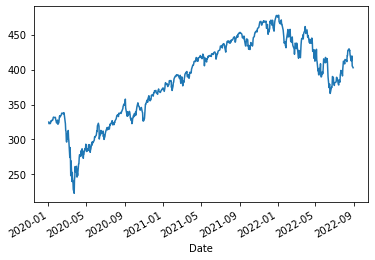

In [8]:
data.loc[:,"Close"].plot()

# Evaluar algoritmos y modelos

In [9]:
#Train-test split
X=list(data["Close"])
X=[float(x) for x in X]
validation_size=0.2
train_size=int(len(X)*(1-validation_size))
X_train, X_test= X[0:train_size],X[train_size:len(X)]


El algoritmo general de este estudio de caso (y del aprendizaje por refuerzo en general) es un poco complejo ya que requiere la construcción de una estructura de código basada en clases y el uso simultáneo de muchos módulos y funciones. Esta sección adicional se agregó para este estudio de caso para proporcionar una explicación funcional de lo que está sucediendo en el programa.

El algoritmo, en términos simples, decide si comprar, vender o retener cuando se le proporciona el precio de mercado actual.

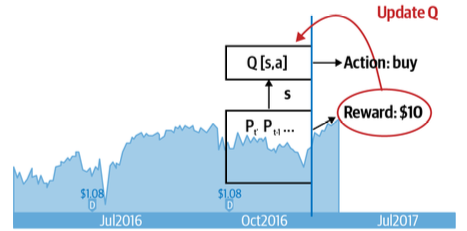

El algoritmo evalúa qué acción tomar en función de un valor Q, que determina el valor de estar en un estado determinado y realizar una acción determinada en ese estado.

El estado o estados se decide sobre la base del comportamiento actual e histórico del precio (Pt, Pt – 1, ...). Según el estado actual, la acción es "comprar". Con esta acción, observamos una recompensa de $ 10 (es decir, el PnL asociado con la acción) y pasamos al siguiente estado. Usando la recompensa actual y el valor Q del siguiente estado, el algoritmo actualiza la función de valor Q. El algoritmo sigue avanzando en los próximos pasos. Dadas las iteraciones suficientes de los pasos anteriores, este algoritmo convergerá al valor Q óptimo. 

La red Q profunda (DQN) que usamos en este estudio de caso usa una ANN para aproximar los Q-values; por tanto, la función de valor de acción se define como Q (s, a; θ). El algoritmo de aprendizaje profundo de Q se aproxima a la función de valor Q mediante el aprendizaje de un conjunto de pesos, θ, de un DQN multicapa que asigna estados a acciones.

La implementación de este algoritmo DQN requiere la implementación de varias funciones y módulos que interactúan entre sí durante el entrenamiento del modelo. 

A continuación, se muestra un resumen de los módulos y funciones:

**Clase de agente**
El agente se define como clase "Agente". Contiene las variables y funciones de los miembros que realizan el Q-learning. Un objeto de la clase Agente se crea usando la fase de entrenamiento y se usa para entrenar el modelo.

**Funciones auxiliares**
En este módulo, creamos funciones adicionales que son útiles para el entrenamiento.

**Modulo de entrenamiento**
En este paso, realizamos el entrenamiento de los datos utilizando las variables y las funciones definidas en los métodos agent y helper. Durante el entrenamiento, se predice la acción (comprar/vender/mantener) prescrita para cada día, se calculan las recompensas y las ponderaciones del modelo de Q-learning basado en el aprendizaje profundo se actualizan de forma iterativa a lo largo de varios episodios. Además, las ganancias y pérdidas de cada acción se suman para determinar si se ha producido una ganancia general. El objetivo es maximizar el beneficio total.

**Clase de agente**. 
La clase de agente consta de los siguientes componentes:

• Constructor

• Modelo de función

• Function act

• Function expReplay

El Constructor se define como función de inicio y contiene parámetros importantes como el factor de descuento para la función de recompensa, épsilon para el enfoque ε-codicioso, el tamaño del estado y el tamaño de la acción. El número de acciones se establece en tres (es decir, comprar, vender y mantener). La variable de memoria define el tamaño de la memoria de reproducción. El parámetro de entrada de esta función también consta del parámetro is_eval, que define si el entrenamiento está en curso. Esta variable se cambia a Verdadero durante la fase de evaluación / prueba. Además, si el modelo preentrenado debe usarse en la fase de evaluación / entrenamiento, se pasa usando la variable model_name:

El **modelo** de función es un modelo de aprendizaje profundo que asigna los estados a las acciones. Esta función toma el estado del entorno y devuelve una tabla de valores Q o una política que se refiere a una distribución de probabilidad sobre las acciones. 
La arquitectura para el modelo de aprendizaje profundo usado es:

• El modelo espera filas de datos con un número de variables igual al tamaño del estado, que viene como entrada.

• La primera, segunda y tercera capas ocultas tienen 64, 32 y 8 nodos, respectivamente, y todas estas capas utilizan la función de activación de ReLU.

• La capa de salida tiene el número de nodos igual al tamaño de la acción (es decir, tres) y el nodo usa una función de activación lineal:

La **función act** devuelve una acción dado un estado. La función usa la función de modelo y devuelve una acción de compra, venta o retención:

La función expReplay es la función clave, donde se entrena la red neuronal en función de la experiencia observada. Esta función implementa el mecanismo de reproducción de Experience como se discutió anteriormente. La reproducción de experiencias almacena un historial de transiciones de estado, acción, recompensa y siguiente estado que experimenta el agente. Toma un mini lote de observaciones (memoria de reproducción) como entrada y actualiza las ponderaciones del modelo de Q-learning basado en el aprendizaje profundo minimizando la función de pérdida. El enfoque codicioso de épsilon implementado en esta función evita el sobreajuste. Para explicar la función, los diferentes pasos se enumeran en los comentarios del siguiente código de Python, junto con un esquema de los pasos:
1. Prepare la memoria intermedia de repetición, que es el conjunto de observación utilizado para el entrenamiento. Se agregan nuevas experiencias a la memoria intermedia de reproducción mediante un bucle for.
2. Recorra todas las observaciones de estado, acción, recompensa y las siguientes transiciones de estado en el mini-lote.
3. La variable objetivo de la tabla Q se actualiza según la ecuación de Bellman. La actualización ocurre si el estado actual es el estado terminal o el final del episodio. Esto está representado por la variable done y se define más adelante en la función de entrenamiento. Si no se hace, el objetivo está configurado para recompensar.
4. Predecir el valor Q del siguiente estado utilizando un modelo de aprendizaje profundo.
5. El valor Q de este estado para la acción en el búfer de reproducción actual se establece en el destino.
6. Las ponderaciones del modelo de aprendizaje profundo se actualizan mediante la función model.fit.
7. Se implementa el enfoque épsilon codicioso. Recuerde que este enfoque selecciona una acción al azar con una probabilidad de ε o la mejor acción, de acuerdo con la función de valor Q, con probabilidad 1 – ε.

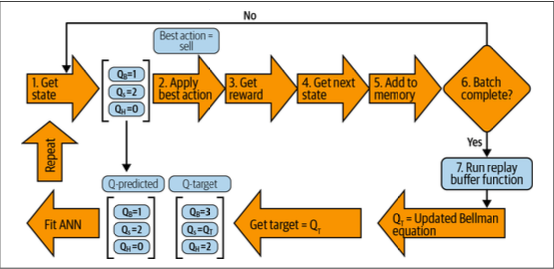

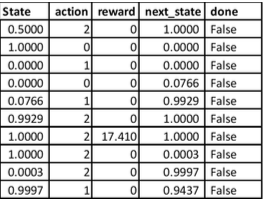

# Bellman Equation

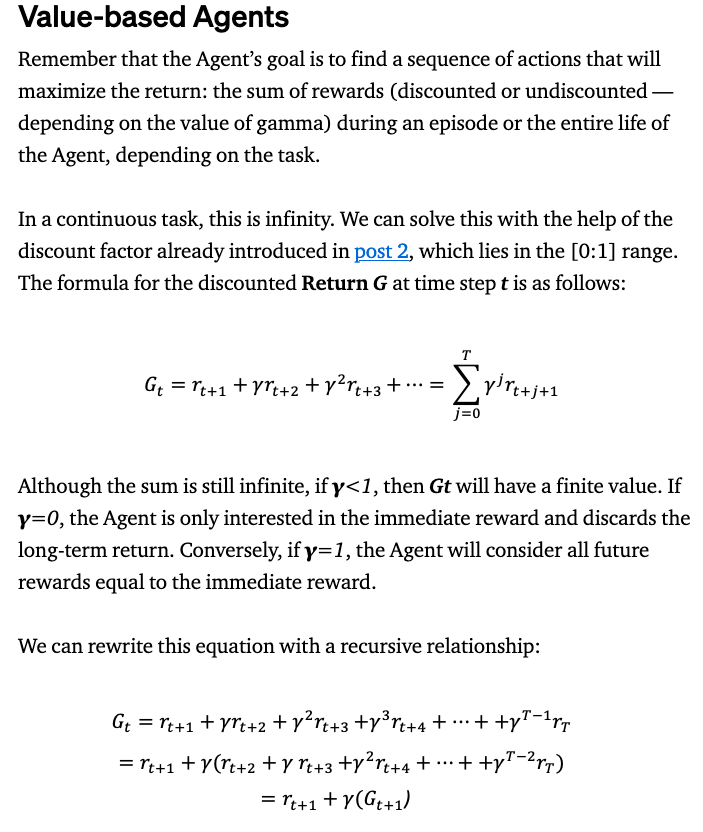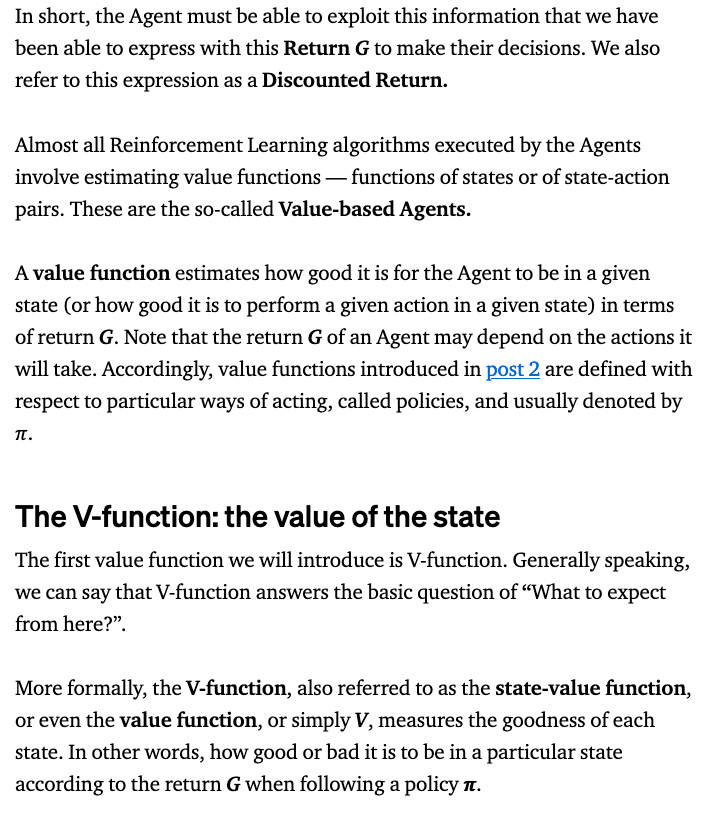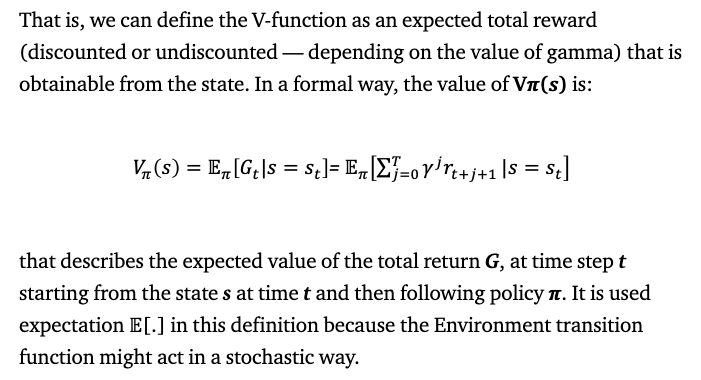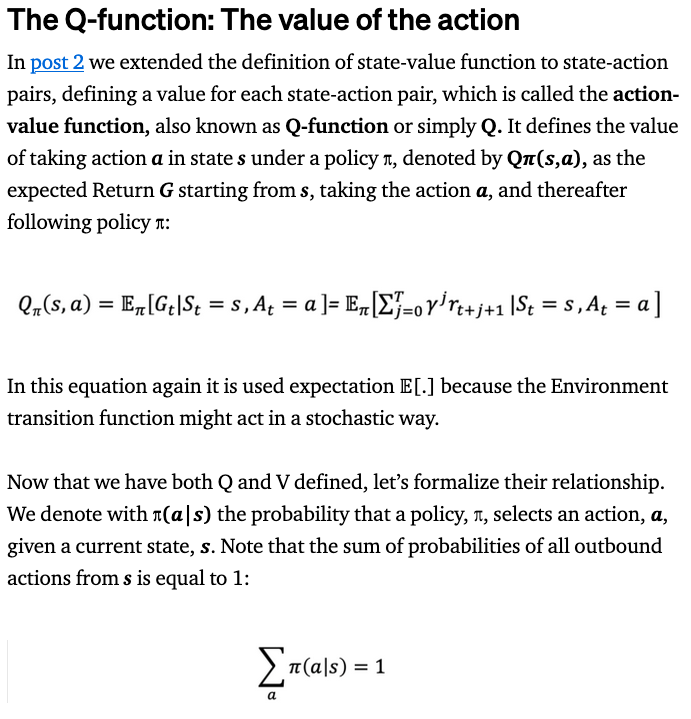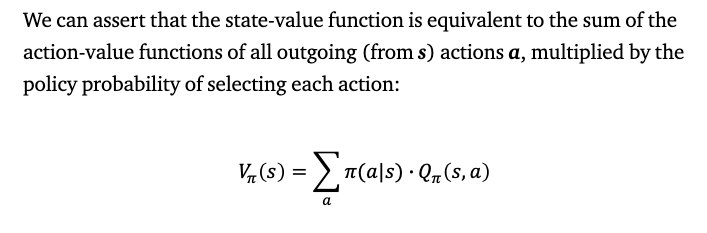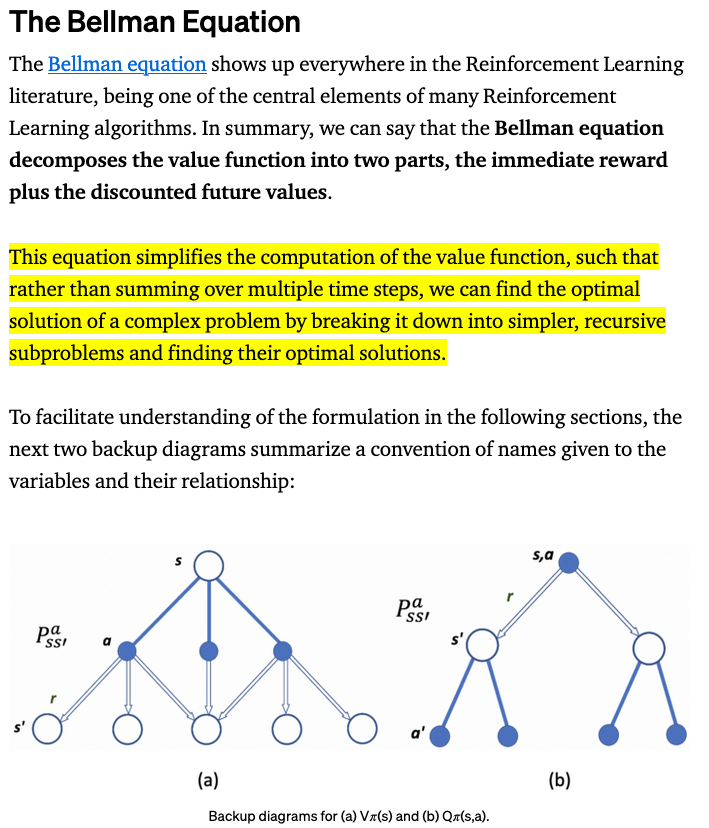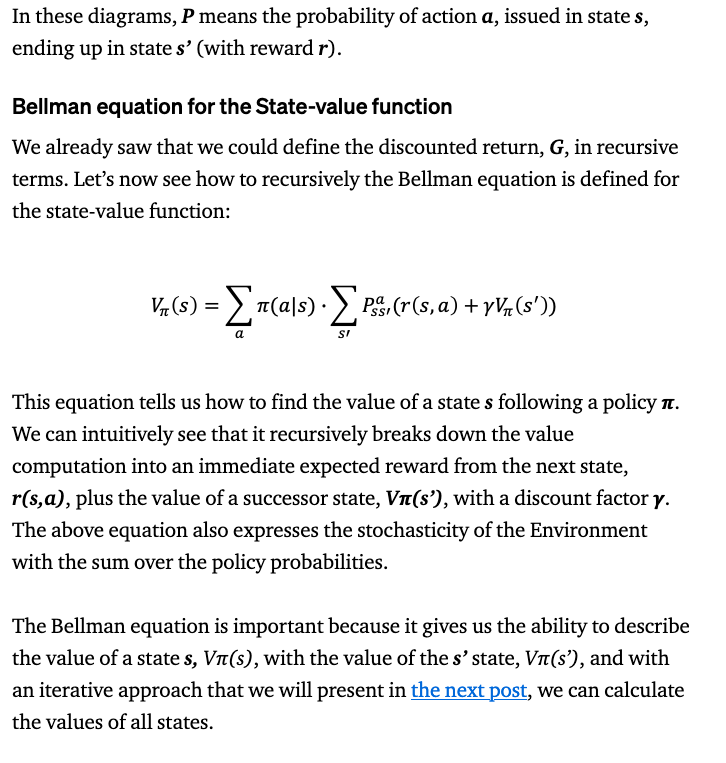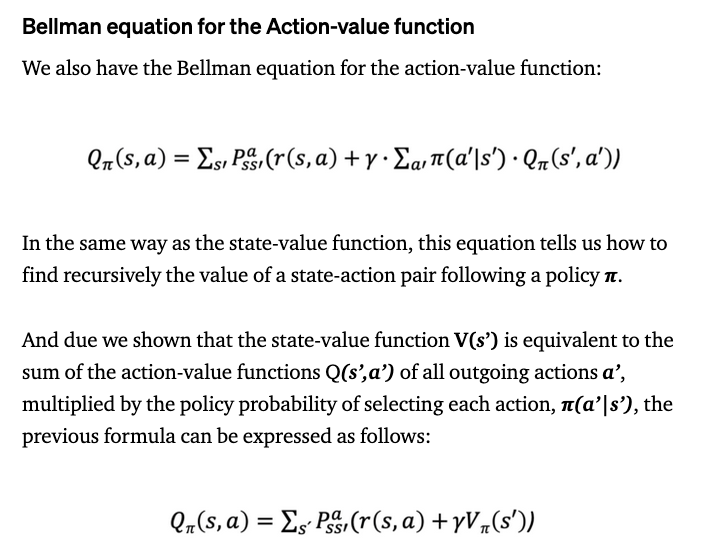

La función getState genera los estados dados los datos de existencias, el tiempo t (el día de la predicción) y la ventana n (número de días para retroceder en el tiempo). Primero, se calcula el vector de diferencia de precio, seguido de escalar este vector de cero a uno con una función sigmoidea. Esto se devuelve como estado.

La función plot_behavior devuelve la gráfica del precio de mercado junto con indicadores para las acciones de compra y venta. Se utiliza para la evaluación general del algoritmo durante la fase de entrenamiento y prueba.

# Variables a Ajustar

De forma similar a otras técnicas de aprendizaje automático, podemos encontrar la mejor combinación de hiperparámetros de modelo en RL mediante el uso de técnicas como la búsqueda en Grid. La búsqueda de Grid para problemas basados en RL es computacionalmente intensiva. Por lo tanto, en esta sección, en lugar de realizar la búsqueda en Grid, presentamos los hiperparámetros clave a considerar, junto con su intuición y su impacto potencial en la salida del modelo.

**Gamma (factor de descuento)**
La **gamma** en decadencia hará que el agente priorice las recompensas a corto plazo a medida que aprende cuáles son esas recompensas y pondrá menos énfasis en las recompensas a largo plazo. Reducir el factor de descuento en este estudio de caso puede hacer que el algoritmo se centre en las recompensas a largo plazo.

**Épsilon**
La variable épsilon controla la propiedad de exploración versus explotación del modelo. Cuanto más conocemos nuestro entorno, menos exploración aleatoria queremos hacer. Cuando reducimos épsilon, la probabilidad de una acción aleatoria se reduce y aprovechamos más oportunidades para beneficiarnos de las acciones de alto valor que ya descubrimos. Sin embargo, en la configuración comercial, no queremos que el algoritmo se sobreajuste a los datos de entrenamiento, y el épsilon debe modificarse en consecuencia.

**Episodios y tamaño de lote**
Un mayor número de episodios y un tamaño de lote más grande en el conjunto de entrenamiento conducirán a un mejor entrenamiento y un valor Q más óptimo. Sin embargo, existe una compensación, ya que al aumentar el número de episodios y el tamaño del lote aumenta el tiempo total de entrenamiento.

**Tamaño de ventana**
El tamaño de la ventana determina la cantidad de días de mercado a considerar para evaluar el estado. Esto se puede aumentar en caso de que queramos que el estado sea determinado por un mayor número de días en el pasado.

**Número de capas y nodos del modelo de aprendizaje profundo**
Esto se puede modificar para un mejor entrenamiento y un valor Q más óptimo.

In [69]:
random.randrange(3)

2

In [49]:
np.amax([1.2,3.5,4.1])

4.1

In [79]:
np.argmax([1.2,3.5,4.1])


2

In [86]:
class Agent: 
    def __init__(self,state_size,is_eval=False,model_name=""):
        self.state_size=state_size #días previos normalizados
        self.action_size=3 #hold,buy,sell
        self.memory=deque(maxlen=1000)
        self.inventory=[]
        self.model_name=model_name
        self.is_eval=is_eval
        self.gamma=0.95
        self.epsilon=1.0
        self.epsilon_min=0.1
        self.epsilon_decay=.995
        self.firtIter=True
        self.model=load("models/"+model_name) if is_eval else self._model()
        

        
    def _model(self):
        model=Sequential()
        model.add(Dense(units=64,input_dim=self.state_size,activation="relu"))
        model.add(Dense(units=32,activation="relu"))
        model.add(Dense(units=8,activation="relu"))
        model.add(Dense(units=8,activation="relu"))
        model.add(Dense(self.action_size,activation="linear"))
        model.compile(loss="mse",optimizer=Adam())
        return model

    def act(self,state):
        rand_val=np.random.rand()
        #El caso cuando todavía no le creo tanto al modelo (explorar)
        if not self.is_eval and rand_val<=self.epsilon:
            #En el rango de 0,1,2, selecciona "uno" de esos
            return random.randrange(self.action_size)

        if (self.firtIter):
            #Si es la pimera iteración, comprar. 
            self.firstIter=False
            return 1 #1 va a ser compra, #2 va a ser venta, #0 mantener
 
    
        #Le voy creyndo más al modelo (explotar)
        options=self.model.predict(state)

        return np.argmax(options[0])

    #El método de Experiencia. Eq. Bellman, Q-value
    def expReplay(self,batch_size):
        mini_batch=[]
        l=len(self.memory)
        #Crear un minibatch accediendo a cada fila de la memoria
        #Ultimas batch_size=10 obsrvacions
        for i in range(l-batch_size+1,l):
            mini_batch.append(self.memory[i])
        #Loop sobre todo nuestro batch
        #Vamos actualizar nuestra Q (reward)
        for state,action,reward,next_state,done in mini_batch:
            target=reward #reward/Q al tiempo t
            #Actualizar el Target de la Tabla (Q)
            if not done: 
                #target=beneficio_hoy + beneficio que esperaría en el futuro
                target=reward+self.gamma* np.amax(self.model.predict(next_state)[0])

            #vamos a ver qué Q-value me pronostican los precios actuales
            target_f=self.model.predict(state)
            #Actualizar el Output de la Tabla para una acción dada
            target_f[0][action]=target

            #Entrenamos y ajustamos
            self.model.fit(state,target_f,epochs=1,verbose=0)

    
        #Implementa lo de la Codicia de qué tanto lo creo al modelo
        if self.epsilon> self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [88]:
agente=Agent(1)

In [84]:
type(agente)

__main__.Agent

In [89]:
agente.epsilon

1.0

In [90]:
agente._model().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 27        
Total params: 2,571
Trainable params: 2,571
Non-trainable params: 0
_________________________________________________________________


In [91]:
#Funciones Auxiliares
import math
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [92]:
def getState(data,t,n):
    #n window_size +1 
    #t el día en el que stamos, vamos iterar por aquí
    d=t-n+1
    block= data[d:t+1] if d>=0 else -d*[data[0]]+data[0:t+1]
    res=[]
    for i in range(n-1):
        res.append(sigmoid(block[i+1]-block[i]))
        return np.array([res])

In [93]:
#format de precio
def formatPrice(n):
    return ("-$" if n<0 else "$") + "{0:.2f}".format(abs(n))

In [94]:
X_train

[324.8699951171875,
 322.4100036621094,
 323.6400146484375,
 322.7300109863281,
 324.45001220703125,
 326.6499938964844,
 325.7099914550781,
 327.95001220703125,
 327.45001220703125,
 328.19000244140625,
 330.9200134277344,
 331.95001220703125,
 331.29998779296875,
 331.3399963378906,
 331.7200012207031,
 328.7699890136719,
 323.5,
 326.8900146484375,
 326.6199951171875,
 327.67999267578125,
 321.7300109863281,
 324.1199951171875,
 329.05999755859375,
 332.8599853515625,
 333.9800109863281,
 332.20001220703125,
 334.67999267578125,
 335.260009765625,
 337.4200134277344,
 337.05999755859375,
 337.6000061035156,
 336.7300109863281,
 338.3399963378906,
 336.95001220703125,
 333.4800109863281,
 322.4200134277344,
 312.6499938964844,
 311.5,
 297.510009765625,
 296.260009765625,
 309.0899963378906,
 300.239990234375,
 312.8599853515625,
 302.4599914550781,
 297.4599914550781,
 274.2300109863281,
 288.4200134277344,
 274.3599853515625,
 248.11000061035156,
 269.32000732421875,
 239.850006103

In [95]:
data=X_train

In [96]:
len(data)

536

In [97]:
a=[1]

In [98]:
a.pop(0)

1

In [99]:
window_size=1
agent=Agent(window_size)
l=len(data)-1
batch_size=10
states_sell=[]
states_buy=[]
episode_count=0 #epoch


for e in range(episode_count+1):
    print("Episod " + str(e) + "/" + str(episode_count))

    #1.- Nos traemos los precios State/precios
    state=getState(data,0,window_size+1)
    total_profit=0
    agent.inventory=[] #Suponmos Primeras compras primeras salidas
    for t in range(l): #itero sobre días
        #Dame la mejor acción (compra/venta/mantener)
        action=agent.act(state)
        #Mantenmos la posición y obtenemos el precio siguinte
        next_state=getState(data,t+1,window_size+1)
        reward=0
        if action==1: #buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            print("Buy: "+ formatPrice(data[t]))

        elif action==2 and len(agent.inventory)>0: #sell
            bought_price=agent.inventory.pop(0)
            #3 Calculamos el reward de la Venta
            reward=max((data[t]-bought_price),0)
            total_profit+=data[t]-bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " ' Profit:'"+ formatPrice(data[t]-bought_price))

        done=True if t==l-1 else False

        #Actualiza la Q de Bellman Next_state
        next_state=getState(data,t+1,window_size+1)
        #Agregar todo a la memoria
        agent.memory.append((state,action,reward,next_state,done))
        state=next_state
        if done:
            print("---")
            print("Total Profil: " + formatPrice(total_profit))
            print("---")
        #Dfinimos cada cuando quermos que actualice el modelo
        if len(agent.memory)>batch_size:
            agent.expReplay(batch_size)
    #Guardamos el modelo
    agent.model.save("models"+str(e))




Episod 0/0
Buy: $322.41
Buy: $323.64
Buy: $322.73
Buy: $324.45
Sell: $326.65 ' Profit:'$4.24
Buy: $325.71
Sell: $327.45 ' Profit:'$3.81


2022-08-29 20:32:03.684015: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Buy: $331.95
Sell: $331.30 ' Profit:'$8.57
Buy: $328.77
Buy: $323.50
Sell: $326.62 ' Profit:'$2.17
Buy: $327.68
Sell: $324.12 ' Profit:'-$1.59
Buy: $329.06
Sell: $332.86 ' Profit:'$0.91
Buy: $333.98
Buy: $332.20
Buy: $334.68
Buy: $335.26
Buy: $337.42
Buy: $336.73
Sell: $338.34 ' Profit:'$9.57
Buy: $336.95
Sell: $322.42 ' Profit:'-$1.08
Buy: $312.65
Buy: $311.50
Buy: $309.09
Buy: $274.23
Sell: $274.36 ' Profit:'-$53.32
Sell: $239.85 ' Profit:'-$89.21
Buy: $252.80
Buy: $240.00
Buy: $240.51
Buy: $228.80
Buy: $222.95
Buy: $243.15
Buy: $246.79
Buy: $261.65
Buy: $246.15
Buy: $251.83
Sell: $248.19 ' Profit:'-$85.79
Sell: $264.86 ' Profit:'-$67.34
Buy: $265.13
Buy: $274.03
Buy: $278.20
Sell: $283.79 ' Profit:'-$50.89
Buy: $279.10
Sell: $286.64 ' Profit:'-$48.62
Buy: $281.59
Buy: $273.04
Sell: $279.10 ' Profit:'-$58.32
Buy: $279.08
Buy: $282.97
Buy: $287.05
Sell: $290.48 ' Profit:'-$46.25
Sell: $282.79 ' Profit:'-$54.16
Sell: $286.19 ' Profit:'-$26.46
Buy: $292.44
Buy: $292.50
Buy: $281.60
Buy:

2022-08-29 20:41:44.763649: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models0/assets


In [100]:
def plot_behavior(data_input,states_buy,states_sell,profit):
    n=len(data_input)
    mdates=dataset[:n].index
    fig=plt.figure(figsize=(15,5))
    plt.plot(mdates,data_input,color="r",lw=2)
    plt.plot(mdates,data_input,"v",markersize=5,color="k",
            label="Selling Signal",markevery=states_sell)
    plt.plot(mdates,data_input,"^",markersize=5,color="m",
            label="Buying Signal",markevery=states_buy)    
    plt.title("Total Gains: %f"%(profit))
    plt.legend()
    plt.show()b

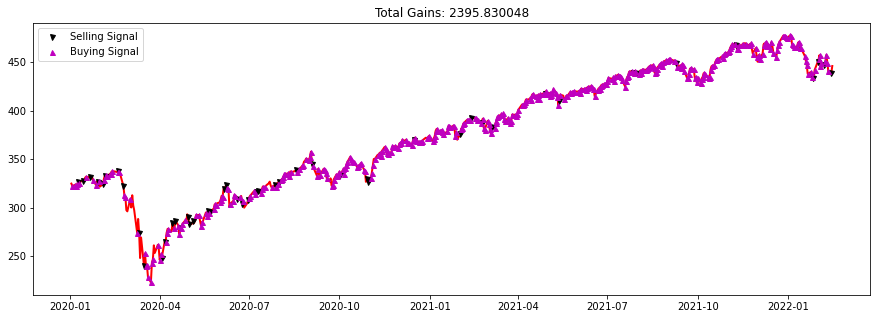

In [101]:
plot_behavior(data_input=data,
             states_buy=states_buy,
             states_sell=states_sell,
             profit=total_profit)

# Testing Data
### En el exame final se preguntaría cómo probar el modelo anterior en el test. 

# Vamos a hacer esto con un Portafolio

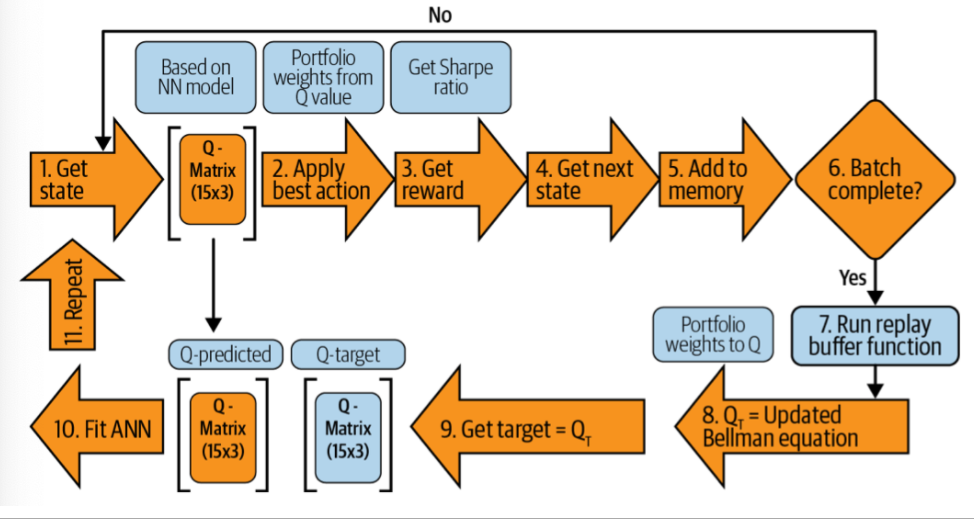

La técnica más utilizada para la construcción de carteras es la optimización de portafolios de media-varianza, la cual tiene varias debilidades, que incluyen:

• Errores de estimación en los rendimientos esperados y matriz de covarianza causados por la naturaleza errática de los rendimientos financieros.

• Optimización cuadrática inestable que compromete en gran medida la optimización de los portafolios resultantes.

Los algoritmos de aprendizaje por refuerzo (RL), con la capacidad de decidir la política por sí mismos, son modelos sólidos para realizar la asignación de portafolios de manera automatizada, sin necesidad de supervisión continua. La automatización de los pasos manuales involucrados en la asignación de portafolios puede resultar inmensamente útil, específicamente para los asesores robóticos (robo-advisores).

Utilizaremos un enfoque basado en Q-learning y DQN para crear una política para la asignación óptima de cartera entre un conjunto de ETFs

Nos centraremos ahora en: 
    
• Definición de los componentes de RL en un problema de asignación de cartera.

• Evaluación de Q-learning en el contexto de asignación de cartera.

• Creación de un entorno de simulación para ser utilizado en el marco de RL.

• Extender el marco de Q-learning utilizado para el desarrollo de estrategias de trading a portafolios.

# Definición de Problema

En el marco de aprendizaje por refuerzo definido para este caso de estudio, el algoritmo realiza una acción, que es la asignación óptima de la cartera, según el estado actual de la cartera. 

El algoritmo se entrena utilizando un marco de Q-learning profundo, y los componentes del modelo son los siguientes:

**Agente**
Un gestor de cartera, un asesor robótico o un inversor individual.

**Acción**
Asignación y reequilibrio de los pesos de la cartera. El modelo DQN proporciona los valores Q, que se convierten en ponderaciones de cartera.

**Función de recompensa**
La relación de Sharpe. Aunque puede haber una amplia gama de funciones de recompensa complejas que proporcionan una compensación entre beneficio y riesgo, como el rendimiento porcentual o la reducción máxima (max drawdown).

**Estado**
El ambiente es la matriz de correlación de los instrumentos en función de una ventana de tiempo específica. La matriz de correlación es una variable de estado adecuada para la asignación de cartera, ya que contiene la información sobre las relaciones entre diferentes instrumentos y puede ser útil para realizar la asignación de cartera.

**Ambiente**
El mercado de ETFs

El conjunto de datos utilizado en este estudio son más de 15 ETFs. Contiene los precios diarios de los ETFs. Los datos contienen algunas de los ETFs más liquidos de diferentes asset classes. . 

# Load Librerías

In [102]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2
from collections import deque

In [103]:
import pandas_datareader.data as web

In [104]:
etfs=([
"ACWF", #multifactor global
"ACWI", #All Country World Index
"ACWV", #Value
"ACWX", #acwi sin usa
"AGG", #ETF más grande de bonos
"AIA", #asia
"AIQ", #Inteligencia artifial
"AMLP", #energía
"ANGL", #Bonos Ángeles
"ASHR", #China
"AUSF", #equity USA. 
"AXP", #American Express
"BA", #Boeing
"BAB", #Bonos Municipales
"BIL"]) #Bonos de Corto Plazo

In [105]:
etfs

['ACWF',
 'ACWI',
 'ACWV',
 'ACWX',
 'AGG',
 'AIA',
 'AIQ',
 'AMLP',
 'ANGL',
 'ASHR',
 'AUSF',
 'AXP',
 'BA',
 'BAB',
 'BIL']

In [106]:
etfs1=web.DataReader(etfs,"yahoo",start="2021-01-01")

In [107]:
etfs1=etfs1.loc[:,("Adj Close")]

In [109]:
etfs1

Symbols,ACWF,ACWI,ACWV,ACWX,AGG,AIA,AIQ,AMLP,ANGL,ASHR,AUSF,AXP,BA,BAB,BIL
Date,,,,,,,,,,,,,,,
2021-01-04,32.677277,87.835884,93.667381,51.033058,114.633194,86.534828,26.826807,22.024427,30.041883,40.309395,24.457617,115.625511,202.720001,32.045822,91.317024
2021-01-05,33.039738,88.741302,94.153206,51.779602,114.516663,88.481750,27.225124,22.933455,30.098146,41.578358,24.611860,116.242638,211.630005,32.045822,91.307053
2021-01-06,33.408039,89.237816,94.619598,51.999737,113.953400,87.767555,26.757099,23.955029,30.060640,41.717152,25.315605,120.542831,211.029999,31.911823,91.317024
2021-01-07,33.827835,90.172455,94.600166,52.277298,113.836876,88.765465,27.324705,24.353266,30.173155,42.738270,25.460213,119.589348,212.710007,31.902256,91.317024
2021-01-08,34.021214,90.970787,95.241447,52.985561,113.700912,91.768997,27.782772,24.041607,30.163774,42.272324,25.392733,119.707306,209.899994,31.835260,91.307053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,33.029999,89.050003,97.669998,45.419998,101.510002,58.660000,22.270000,40.820000,28.030001,31.049999,30.930000,157.330002,160.070007,27.480000,91.480003
2022-08-24,33.075001,89.279999,97.650002,45.459999,101.239998,58.810001,22.250000,41.020000,28.090000,30.299999,31.040001,159.130005,163.600006,27.299999,91.510002
2022-08-25,33.540001,90.599998,98.330002,46.090000,101.800003,60.889999,22.850000,41.290001,28.350000,30.750000,31.230000,162.229996,169.380005,27.549999,91.519997


<AxesSubplot:xlabel='Date'>

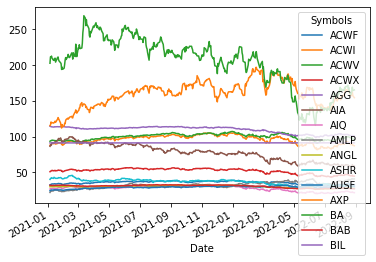

In [110]:
etfs1.plot()

# Evaluar Algoritmos y Modelos

Este es el paso clave del desarrollo del modelo de aprendizaje por refuerzo, donde definiremos todas las funciones y clases y entrenaremos el algoritmo.

**Script de agente y entorno de ETFs**. 

Tenemos una clase Agente que contiene las variables y las funciones miembro que realizan el Q-learning. 

Esto es similar a la clase de agente definida en el ejercicio pasado, **con una función adicional para convertir la salida del valor Q de la red neuronal profunda en ponderaciones de cartera y viceversa**

El módulo de entrenamiento implementa la iteración a través de varios episodios y batches y guarda la información del estado, la acción, la recompensa y el siguiente estado para usar en el entrenamiento. 

Implementamos un entorno de simulación para ETFs usando una clase llamada ETFEnvironment. 

El concepto de entorno de simulación, o gym, es bastante común en los problemas de RL. 

Uno de los desafíos del aprendizaje por refuerzo es la falta de entornos de simulación disponibles en los que experimentar. OpenAI gym es un conjunto de herramientas que proporciona una amplia variedad de entornos simulados (por ejemplo, juegos de Atari, simulaciones físicas 2D/3D), para que podamos entrenar agentes, compararlos o desarrollar nuevos algoritmos de RL. 

Además, se desarrolló con el objetivo de convertirse en un entorno estandarizado y un punto de referencia para la investigación de RL. 

Introducimos un concepto similar en la clase ETFEnvironment, donde creamos un entorno de simulación para ETFs. 


Esta clase tiene las siguientes funciones clave:

**getState**

Esta función devuelve el estado, así como la devolución histórica o los datos históricos sin procesar según el indicador is_cov_matrix o is_raw_time_series

**getReward**

Esta función devuelve la recompensa (es decir, la relación de Sharpe) de la cartera, dadas las ponderaciones de la cartera y el período retrospectivo.

# ETF Environment

In [111]:
#Definir una función portafolio que calcule rends y vols históricas

def portfolio(returns,weights):
    weights=np.array(weights)
    rets=returns.mean()*252
    covs=returns.cov()*252
    P_ret=np.sum(rets*weights)
    P_vol=np.sqrt(np.dot(weights.T,np.dot(covs,weights)))
    P_sharpe=P_ret/P_vol
    return np.array([P_ret,P_vol,P_sharpe])




In [112]:
class ETFEnvironment: 
    def __init__(self,prices=etfs1,capital=1e6):
        self.prices=prices
        self.capital=capital
        self.data=self.load_data()

    def load_data(self):
        data=etfs1
        return data   

    def preprocess_state(self,state):
        return state

    
    def get_state(self,t,lookback,is_cov_matrix=True,is_raw_time_series=False):

        assert lookback<=t
       
        decision_making_state=self.data.iloc[t-lookback:t]
        
        decision_making_state=decision_making_state.pct_change().dropna()

        if is_cov_matrix:
            x=decision_making_state.cov()
            return x

        else:
            if is_raw_time_series:
                decision_making_state=self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)


    def get_reward(self,action,action_t,reward_t,alpha=.01):



        def local_portfolio(returns,weights):
            
            weights=np.array(weights)
            rets=returns.mean()#*252
            covs=returns.cov()#*252
            P_ret=np.sum(rets*weights)
            P_vol=np.sqrt(np.dot(weights.T,np.dot(covs,weights)))
            P_sharpe=P_ret/P_vol
            return np.array([P_ret,P_vol,P_sharpe])

        data_period=self.data[action_t:reward_t]
        weights=action
        returns=data_period.pct_change().dropna()
        sharpe=local_portfolio(returns,weights)[-1]

            
            
        sharpe=np.array([sharpe]*len(self.data.columns))

        rew=(data_period.values[-1]-data_period.values[0])/data_period.values[0]

            
        return np.dot(returns,weights), sharpe




# Agent

Ahora entrenaremos a un agente que realizará un aprendizaje por refuerzo basado en las redes del actor y el crítico. 

Realizaremos los siguientes pasos para conseguirlo:

Crearemos una clase de agente cuya función inicial tenga en cuenta el tamaño del batch, el tamaño del estado y una función booleana de evaluación para verificar si training está en curso.

En la clase de agente, se crearán los siguientes métodos:

    - Cree una función de reproducción que agregue, muestree y evalúe un búfer.
    - Agregue una nueva experiencia a la memoria del búfer de reproducción
    - Muestra aleatoriamente un lote de tuplas experimentadas de la memoria. En la siguiente función, muestreamos aleatoriamente los estados de un búfer de memoria. Hacemos esto para que los estados que alimentamos al modelo no estén temporalmente correlacionados. Esto reducirá el sobreajuste
    
- Devuelve el tamaño actual de la memoria intermedia
- El número de acciones se define como 3: mantener, comprar, vender
- Definir el tamaño de la memoria de reproducción
- La función de recompensa es el retorno.

In [113]:
class Agent: 
    def __init__(self,portfolio_size,is_eval=False,allow_short=True):
        
        self.portfolio_size=portfolio_size
        self.allow_short=allow_short
        self.input_shape=(portfolio_size,portfolio_size,) #recibe matriz de var-cov        
        
        self.action_size=3 #hold/sit, buy, sell
        self.memory4replay=[]

        self.is_eval=is_eval
        self.gamma=0.95
        self.epsilon=1.0
        self.epsilon_min=.01
        self.epsilon_decay=.99

        
        self.firstIter=True
        self.alpha=0.5
        self.model=self._model()

        
    def _model(self):
        inputs=Input(shape=self.input_shape)
        x=Flatten()(inputs)
        x=Dense(100,activation='elu')(x)
        x=Dropout(0.5)(x)
        x=Dense(50,activation="elu")(x)
        x=Dropout(0.5)(x)
        predictions=[]

        for i in range(self.portfolio_size):
            asset_dense=Dense(self.action_size,activation='linear')(x)
            predictions.append(asset_dense)

        model=Model(inputs=inputs,outputs=predictions)
        model.compile(optimizer='adam',loss='mse')
        return model    
    
    
    
    def nn_pred_to_weights(self,pred,allow_short=False):
        weights=np.zeros(len(pred))
        raw_weights=np.argmax(pred,axis=-1)

        saved_min=None
        for e, r in enumerate(raw_weights):

            if r==0: #hold/mantener/sit
                weights[e]=0

                
            elif r==1: #buy
                weights[e]=np.abs(pred[e][0][r]) #aquí estoy accediendo al valor de Q asociado a la "Compra" 
                #y lo esoty poniendo como peso. Es la "Compra" porque es el valor máximo contra Venta y Mantener. 
            else: 
                weights[e]=-np.abs(pred[e][0][r]) #el negativo es porque lo estás vendiendo

                
        #Sumar valores absolutes 
        if not allow_short: #Es el caso en el que quiero todo positivo. Le sumamos el mínimo a todo para 
            #que fuera todo positivo 
            weights += np.abs(np.min(weights))
            saved_min=np.abs(np.min(weights))
            saved_sum=np.sum(weights)
        else: 
            saved_sum=np.sum(np.abs(weights)) #aquí solamente es el denominador =que sume 1. 
        #sí permito números negativos irme corto. Allow_short=True l
        weights /= saved_sum
        return weights, saved_min, saved_sum

    
    def act(self,state):
        #El caso cuando todavía no le creo tanto al modelo (explorando)

        if not self.is_eval and random.random()<=self.epsilon:
            
            #Que les dé pesos random
            
            #Si no le creo al modelo tengo que desarrolar lo de cuando sí le creo: que es cuando 
            #se permiten ventas en corto y que sume 1. 
            w=np.random.normal(0,1,size=(self.portfolio_size,))
            saved_min=None
            if not self.allow_short:
            #cuando no permito ventas en corto me aseguro que todo 
            #esté positivo
                w += np.abs(np.min(w))
                saved_min=np.abs(np.min(w))
            #sí permito ventas en corto, aquí hay valores negativos
            saved_sum=np.sum(w)
            w /= saved_sum
            return w, saved_min, saved_sum

       #donde sí le creo a mi modelo y lo exploto
        pred=self.model.predict(np.expand_dims(state.values,0))

        return self.nn_pred_to_weights(pred,self.allow_short)

                

       #El método de Experiencia. Eq Bellman, Q-value
    def expReplay(self,batch_size):

        def weights_to_nn_preds_with_reward(action_weights,
                                           reward,
                                           Q_star=np.zeros((self.portfolio_size,self.action_size))):
            Q=np.zeros((self.portfolio_size,self.action_size))

            for i in range(self.portfolio_size):
                if action_weights[i]==0:
                    Q[i][0]=reward[i] + self.gamma*np.max(Q_star[i][0]) #aquí np.max hace que te arroje float
          
        
                elif action_weights[i]>0:
                    Q[i][1]=reward[i] + self.gamma*np.max(Q_star[i][1])

                else:
                    Q[i][2]=reward[i] + self.gamma*np.max(Q_star[i][2])  
            return Q
        
        def restore_Q_from_weights_and_stats(action):
            #action serán los weights que arroja su modelo: su red (return weights, saved_min, saved_sum)
            #estamos haciendo esto para reconstruir Q, desde los weights y cada entrada
            action_weights, action_min, action_sum=action[0],action[1], action[2]
            action_weights=action_weights*action_sum

            if action_min != None:
                action_weights=action_weights-action_min
            return action_weights

        #Vamos a actualizar nuestra Q (reward)
        for (s,s_,action,reward,done) in self.memory4replay:

            action_weights=restore_Q_from_weights_and_stats(action)
            Q_learned_value=weights_to_nn_preds_with_reward(action_weights,reward)
            s, s_ =s.values, s_.values
            if not done: 
                Q_star=self.model.predict(np.expand_dims(s_,0))
                Q_learned_value=weights_to_nn_preds_with_reward(action_weights,reward,np.squeeze(Q_star))

            Q_learned_value=[xi.reshape(1,-1) for  xi in Q_learned_value]
            Q_current_value=self.model.predict(np.expand_dims(s,0))

            Q=[ np.add(a*(1-self.alpha),q*self.alpha) for a, q in zip(Q_current_value,Q_learned_value)]

            self.model.fit(np.expand_dims(s,0),Q,epochs=1,verbose=0)

        #Implementar lo de la Codicia de qué tanto le creo a mi 
        #modelo
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay           
      

In [114]:
N_ASSETS=15
agent=Agent(N_ASSETS)

In [115]:
env=ETFEnvironment()

In [116]:
window_size=180
episode_count=1
batch_size=32
rebalance_period=90

In [118]:
data_length=len(env.data)
data_length

417

In [119]:
#al menos piden 6 meses para calcular matriz de var-cov
#que llegue hata el total de obsrevaciones
#y que haga rebalanceos cada 90 días. 
for t in range(window_size,data_length,rebalance_period):
    print(t)

180
270
360


Episode 0/1 epsilon 1.0


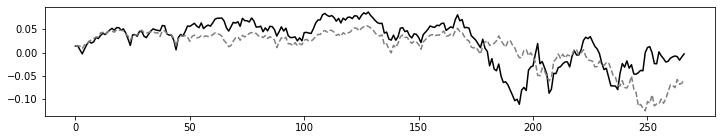

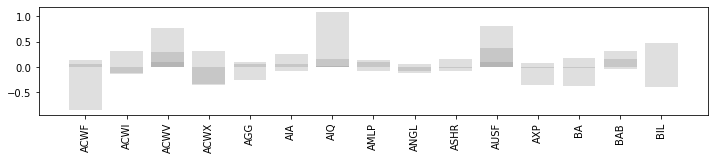

Episode 1/1 epsilon 1.0


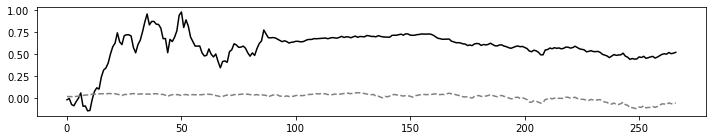

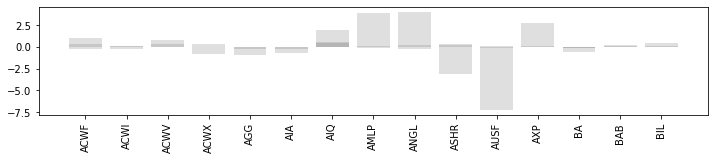

In [121]:
for e in range(episode_count+1):
    agent.is_eval=False
    data_length=len(env.data)

    
    
    returns_history=[]
    returns_history_equal=[]

    
    rewards_history=[]
    equal_rewards=[]

    actions_to_show=[]

    
    
    print("Episode " + str(e) + "/" + str(episode_count),'epsilon',agent.epsilon)

    
    
    
    #1 Generamos Estado/Precios
    s=env.get_state(np.random.randint(window_size+1,data_length-window_size-1),window_size)
    total_profit=0
    for t in range(window_size,data_length,rebalance_period):
        date1=t-rebalance_period
        s_=env.get_state(t,window_size)
        action=agent.act(s_)

        actions_to_show.append(action[0])
        weighted_return,reward=env.get_reward(action[0],date1,t)

        weighted_return_equal,reward_equal=env.get_reward(
            np.ones(agent.portfolio_size)/agent.portfolio_size,date1,t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)

        returns_history.extend(weighted_return)
        returns_history_equal.extend(weighted_return_equal)        

        done=True if t==data_length else False
        agent.memory4replay.append((s,s_,action,reward,done))

        #Cada cuando va a actualizar el modelo
        if len(agent.memory4replay)>batch_size:

            agent.expReplay(batch_size)
            agent.memory4replay=[]
        s=s_

        
    r1_result=np.array(returns_history).cumsum()
    equal_result=np.array(returns_history_equal).cumsum()

    
    plt.figure(figsize=(12,2))
    plt.plot(r1_result,color='black',ls="-")
    plt.plot(equal_result,color='grey',ls="--")
    plt.show()

    
    plt.figure(figsize=(12,2))
    for a in actions_to_show:
        plt.bar(np.arange(N_ASSETS),a,color='grey',alpha=0.25)

        plt.xticks(np.arange(N_ASSETS),env.data.columns,rotation="vertical")
    plt.show()

    

# Training

La cartera RL tiene una mayor rentabilidad, mayor sharpe, menor volatilidad, mayor alfa y correlación negativa con el índice de referencia.

La idea en este estudio de caso era ir más allá de la frontera eficiente clásica de Markowitz y aprender directamente la política de cambiar los pesos dinámicamente en el continuo
mercado cambiante.

Creamos un entorno de trabajo estandarizado
ment ("gimnasio") para etfs para facilitar el entrenamiento. El modelo comienza a aprender durante un período de tiempo, descubre la estrategia
y empieza a explotarlo. usamos el conjunto de prueba para evaluar el modelo y encontramos un
ganancia total en el conjunto de prueba.

En general, el marco proporcionado en este estudio de caso puede permitir a los profesionales financieros
para realizar la asignación y el reequilibrio de la cartera con un sistema muy flexible y automatizado
enfoque y puede resultar inmensamente útil, específicamente para robo-advisors